# Stock Prediction with Recurrent Neural Network

Deep learning is involved a lot in the modern quantitive financial field. There are many different neural networks can be applied to stock price prediction problems. The recurrent neural network, to be specific, the Long Short Term Memory(LSTM) network outperforms others architecture since it can take advantage of predicting time series (or sequentially) involved result with a specific configuration.

We will make a really simple LSTM with Keras to predict the stock price in the Chinese stock.

In [2]:
!pip install Keras


In [24]:
pip install tushare

  Obtaining dependency information for tushare from https://files.pythonhosted.org/packages/ef/8d/6a18c929b55418b33c7740e49ce4ee81ab85e915b121f81731fc96d770cf/tushare-1.4.6-py3-none-any.whl.metadata
  Obtaining dependency information for simplejson from https://files.pythonhosted.org/packages/b6/8e/3e12d122dfdf549a8d12eaf39954ee39f2027060aa38b63430f8ab3244e7/simplejson-3.19.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for bs4 from https://files.pythonhosted.org/packages/51/bb/bf7aab772a159614954d84aa832c129624ba6c32faa559dfb200a534e50b/bs4-0.0.2-py2.py3-none-any.whl.metadata
  Obtaining dependency information for websocket-client==0.57.0 from https://files.pythonhosted.org/packages/4c/5f/f61b420143ed1c8dc69f9eaec5ff1ac36109d52c80de49d66e0c36c3dfdf/websocket_client-0.57.0-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/255.5 kB ? eta -:--:--
   --- ----------------------------------- 20.5/255.5 kB 640.0 kB/s eta 0:00:01
   ---- --

In [4]:
pip show Keras


Name: keras
Version: 3.3.2
Summary: Multi-backend Keras.
Home-page: https://github.com/keras-team/keras
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache License 2.0
Location: c:\Users\Janhavi Patil\anaconda\Lib\site-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, rich
Required-by: tensorflow-intel
Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install git+https://github.com/keras-team/keras.git


  Cloning https://github.com/keras-team/keras.git to c:\users\janhavi patil\appdata\local\temp\pip-req-build-a39zoalv
  Resolved https://github.com/keras-team/keras.git to commit 3ebb36fce26c37b5095853a605f07c5f18b57597
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/keras-team/keras.git 'C:\Users\Janhavi Patil\AppData\Local\Temp\pip-req-build-a39zoalv'


In [9]:
!pip install tensorflow


In [10]:
import time
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep

## Import Data

I have introduced how we get this dataset both in README.md and in another notebook.

In [11]:
df = pd.read_csv('000002-from-1995-01-01.csv')
df.head()

,open,high,low,volume,amount,close
0,20.64,20.64,20.37,16362363.0,3.350027e+08,20.56
1,20.92,20.92,20.60,21850597.0,4.520071e+08,20.64
2,21.00,21.15,20.72,26910139.0,5.628396e+08,20.94
3,20.70,21.57,20.70,64585536.0,1.363421e+09,21.02
4,20.60,20.70,20.20,45886018.0,9.382043e+08,20.70


## Preprocess Data

We can see from the table above that the scales of our features vary a lot. It will be beneficial to normalize your training data before you feed data into your model. "Having different features with widely different scales fed to your model will cause the network to weight the features not equally. This can cause a falsely prioritisation of some features over the others in the representation." Read [here](http://stackoverflow.com/a/43526354/6670143) for more detailed explanation.

In [12]:
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test

Split the data to X_train, y_train, X_test, y_test

In [13]:
def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.values
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]
    
    train, result = standard_scaler(train, result)
    
    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

## Build the LSTM Network

Here we will build a simple RNN with 2 LSTM layers.
The architecture is:
    
    LSTM --> Dropout --> LSTM --> Dropout --> Fully-Conneted(Dense)

In [14]:
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.4))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [15]:
window = 20
X_train, y_train, X_test, y_test = preprocess_data(df[:: -1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (4648, 20, 6)
y_train (4648,)
X_test (516, 20, 6)
y_test (516,)


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout

def build_model(layers):
    model = Sequential()
    # By setting return_sequences to True, we can stack another LSTM layer
    model.add(LSTM(units=layers[1], input_shape=(None, layers[0]), return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(units=layers[2], return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(units=layers[3]))
    model.add(Activation("linear"))

    model.compile(loss="mse", optimizer="rmsprop")
    return model

# Usage:
model = build_model([X_train.shape[2], window, 100, 1])


c:\Users\Janhavi Patil\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Training the Network

You can play with the hyperparameters here. The training process can take a significant time if you are using a average GPU or CPU(worse!).

In [18]:
model.fit(
    X_train,
    y_train,
    batch_size=768,
    epochs=5,
    validation_split=0.1,
    verbose=0)

In [20]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))


Train Score: 0.06 MSE (0.24 RMSE)
Test Score: 0.18 MSE (0.42 RMSE)


## Visualize the Prediction

In [21]:
diff = []
ratio = []
pred = model.predict(X_test)
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [25]:
# TODO: Scale it back
def scale_back_predictions(predictions, preprocessor):
    # Reshape predictions to fit the inverse transformation
    predictions_reshaped = np.array(predictions).reshape(-1, 1)

    # Inverse transform the scaled predictions
    scaled_back_predictions = preprocessor.inverse_transform(predictions_reshaped)

    # Extract the scaled back values
    scaled_back_values = scaled_back_predictions.flatten()

    return scaled_back_values


In [33]:
import time
import math
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation

## Import Data
df = pd.read_csv('000002-from-1995-01-01.csv')
df.head()

## Preprocess Data
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test

def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.values
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]
    
    train, result = standard_scaler(train, result)
    
    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

## Build the LSTM Network
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        units=layers[1],
        input_shape=(None, layers[0]),
        return_sequences=True))
    model.add(Dropout(0.4))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(
        units=layers[3]))
    model.add(Activation("linear"))

    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    return model

window = 20
X_train, y_train, X_test, y_test = preprocess_data(df[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

model = build_model([X_train.shape[2], window, 100, 1])

## Training the Network
model.fit(
    X_train,
    y_train,
    batch_size=768,
    epochs=5,
    validation_split=0.1,
    verbose=0)

trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

## Visualize the Prediction
pred = model.predict(X_test)

# Reshape X_train to 2D array
X_train_2d = X_train.reshape(-1, X_train.shape[2])

# Fit StandardScaler to the reshaped X_train
preprocessor = prep.StandardScaler().fit(X_train_2d)

# Scale back predictions
def scale_back_predictions(predictions, preprocessor):
    # Reshape predictions to fit the inverse transformation
    predictions_reshaped = np.array(predictions).reshape(-1, 1)

    # Inverse transform the scaled predictions
    scaled_back_predictions = preprocessor.inverse_transform(predictions_reshaped)

    # Extract the scaled back values
    scaled_back_values = scaled_back_predictions.flatten()

    return scaled_back_values






X_train (4648, 20, 6)
y_train (4648,)
X_test (516, 20, 6)
y_test (516,)


c:\Users\Janhavi Patil\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Train Score: 0.05 MSE (0.23 RMSE)
Test Score: 0.24 MSE (0.49 RMSE)
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


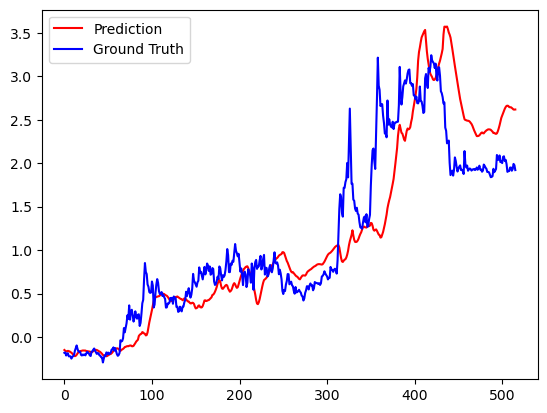

In [35]:
# if using within a Jupyter notebook
%matplotlib inline 

import matplotlib.pyplot as plt

plt.plot(pred, color='red', label='Prediction')
plt.plot(y_test, color='blue', label='Ground Truth')
plt.legend(loc='upper left')
plt.show()